## Ensemble Model (Type : Stacking)
Base Models : Naive Bayes, SVM, LSTM, XGboost, Transformer </br>
Meta Learner : Random Forest

In [7]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import pad_sequences, custom_object_scope
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense, Embedding, GlobalAveragePooling1D, LayerNormalization, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.optimizers import Adam


with open('svm_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('xgb_tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('LSTM_label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('naive_bayes_model.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('nb_tfidf_vectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the transformer model and associated files
with open('Tlabel_encoder.pkl', 'rb') as file:
    t_label_encoder = pickle.load(file)

with open('Tvectorize_layer.pkl', 'rb') as file:
    t_vectorize_layer = pickle.load(file)

# Define the custom layers
class EmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs): # Add **kwargs
        super(EmbeddingLayer, self).__init__(**kwargs) # Pass **kwargs to super()
        self.word_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, tokens):
        sequence_length = tf.shape(tokens)[-1]
        positions = tf.range(start=0, limit=sequence_length, delta=1)
        positions_encoding = self.position_embedding(positions)
        words_encoding = self.word_embedding(tokens)
        return positions_encoding + words_encoding

class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim, **kwargs): # Add **kwargs
        super(EncoderLayer, self).__init__(**kwargs)  # Pass **kwargs to super()
        self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)
        self.nnw = Sequential([Dense(total_dense_units, activation="relu"), Dense(embed_dim)])
        self.normalize_layer = LayerNormalization()

    def call(self, inputs):
        attn_output = self.multihead(inputs, inputs)
        normalize_attn = self.normalize_layer(inputs + attn_output)
        nnw_output = self.nnw(normalize_attn)
        final_output = self.normalize_layer(normalize_attn + nnw_output)
        return final_output

# Load the saved transformer model with custom objects
custom_objects = {
    "EmbeddingLayer": EmbeddingLayer,
    "EncoderLayer": EncoderLayer
}

transformer_model = load_model('Ttransformer_model.h5', custom_objects=custom_objects)


# Load the test dataset
data = pd.read_csv('Twitter_Data.csv')
data.dropna(subset=['tweets'], inplace=True)

X_test = data['tweets']
y_test = data['label']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')
# Preprocess the text for the transformer model
X_test_transformer = t_vectorize_layer(X_test)

# Get individual model probabilities
# svm_predictions_proba = svm_model.predict_proba(X_test_svm) # This line is causing the error
svm_predictions = svm_model.predict(X_test_svm)  # Get predictions instead of probabilities
svm_predictions_proba = to_categorical(svm_predictions, num_classes=3)  # Convert predictions to one-hot encoded probabilities

nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)
# Get probabilities from the transformer model
transformer_predictions_proba = transformer_model.predict(X_test_transformer)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    svm_predictions_proba,  # Use the one-hot encoded probabilities for SVM
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba,
    transformer_predictions_proba  # Add transformer probabilities
))

# Split data into training and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    stacked_features, y_test, test_size=0.2, random_state=42, stratify=y_test
)

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    max_depth=None,            # Maximum depth of each tree
    min_samples_split=20,      # Minimum number of samples to split a node

    min_samples_leaf=1,        # Minimum number of samples in a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    bootstrap=False,            # Whether to use bootstrapping

    random_state=42            # For reproducibility
    )
meta_learner_rf.fit(X_train1, y_train1)

# Save the trained Random Forest meta-learner
with open('meta_learner_rf.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Predict using the Random Forest meta-learner
final_predictions_rf = meta_learner_rf.predict(X_test1)

# Evaluate the Random Forest ensemble model
accuracy_rf = accuracy_score(y_test1, final_predictions_rf)

# Convert label_encoder.classes_ to a list of strings
target_names = [str(cls) for cls in label_encoder.classes_]

report_rf = classification_report(y_test1, final_predictions_rf, target_names=target_names)

print(f"Random Forest Meta-Learner Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report (Random Forest):\n", report_rf)
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test1, final_predictions_rf))

# Calculate the mean and standard deviation of validation accuracies
cross_val_accuracies = cross_val_score(
    meta_learner_rf, stacked_features, y_test, cv=5, scoring='accuracy'
)

mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")

5094/5094 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step
5094/5094 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step
Random Forest Meta-Learner Accuracy: 98.36%
Classification Report (Random Forest):
               precision    recall  f1-score   support

          -1       0.97      0.96      0.97      7102
           0       1.00      0.99      0.99     11043
           1       0.98      0.99      0.98     14451

    accuracy                           0.98     32596
   macro avg       0.98      0.98      0.98     32596
weighted avg       0.98      0.98      0.98     32596

Confusion Matrix (Random Forest):
 [[ 6853    29   220]
 [   46 10942    55]
 [  160    24 14267]]
Cross-Validation Accuracies: [0.98263591 0.98481409 0.98346423 0.98370916 0.98254333]
Mean Validation Accuracy: 98.34%
Validation Accuracy Std Dev: 0.08%


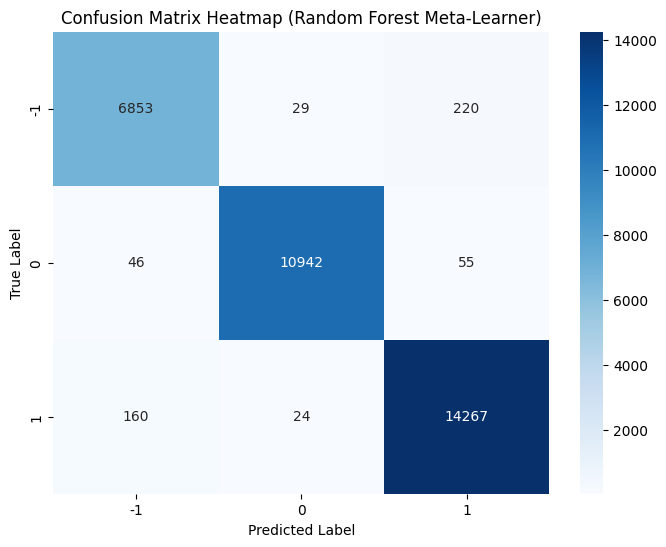

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test1, final_predictions_rf)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)

# Labels, title, and formatting
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap (Random Forest Meta-Learner)")
plt.show()


## Testing with tweets.csv

In [9]:
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.utils import pad_sequences

# Load the trained meta-learner model
with open('meta_learner_rf.pkl', 'rb') as file:
    meta_learner_rf = pickle.load(file)

# Load preprocessed dataset
df_new = pd.read_csv('preprocessed_tweets.csv')
df_new.dropna(subset=['cleaned_text'], inplace=True)

X_new = df_new['cleaned_text']  # Extract tweets

# Preprocess the text using the same vectorizers and tokenizers as before
X_new_svm = svm_vectorizer.transform(X_new)
X_new_nb = nb_vectorizer.transform(X_new)
X_new_xgb = tfidf_vectorizer.transform(X_new)

X_new_lstm = lstm_tokenizer.texts_to_sequences(X_new)
X_new_lstm = pad_sequences(X_new_lstm, maxlen=100, padding='post', truncating='post')

X_new_transformer = t_vectorize_layer(X_new)

# Get individual model probabilities
svm_predictions = svm_model.predict(X_new_svm)
svm_predictions_proba = to_categorical(svm_predictions, num_classes=3)

nb_predictions_proba = nb_model.predict_proba(X_new_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_new_xgb)
lstm_predictions_proba = lstm_model.predict(X_new_lstm)
transformer_predictions_proba = transformer_model.predict(X_new_transformer)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features_new = np.hstack((
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba,
    transformer_predictions_proba
))

# Predict using the trained meta-learner
final_predictions_new = meta_learner_rf.predict(stacked_features_new)

# Convert numeric labels back to original class names
sentiments = label_encoder.inverse_transform(final_predictions_new)

# Add sentiment column to the DataFrame
df_new['sentiments'] = sentiments

# Save the output to a new CSV file
df_new.to_csv('predicted_tweets_ensemble.csv', index=False)

print("Predictions saved to meta_learner_predictions.csv")
print(df_new.head())

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Predictions saved to meta_learner_predictions.csv
                                                Text  \
0  Excited to have Larry Ellison &amp; Kathleen W...   
1  When one of the interns working on the simulat...   
2                           @5AllanLeVito Got it 😀🇺🇦   
3  Yes. Supercharger coverage will extend to 100%...   
4                     @demishassabis Congratulations   

                                        cleaned_text  sentiments  
0  excited larry ellison amp kathleen wilsonthomp...           1  
1          one interns working simulation drops ball           0  
2                                                got           0  
3  yes supercharger coverage extend europe next y...           0  
4                                    congratulations           0  
